In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from importlib.resources import files
from itertools import chain

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from biobank_olink.clustering import (
    score_clustering, get_cluster_labels, plot_clustering,
    explain_clusters, get_embedding, to_test_cases, visualize_clustering, print_best_features
)

warnings.filterwarnings("ignore")

shap.initjs()
DATA_DIR = files("biobank_olink.data")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
df = pd.read_csv(DATA_DIR / "olink_data_ins0.csv", index_col=0)
df

,ABCA2,ABL1,ABO,ACADM,ACE,ACHE,ACP1,ACP6,ACRBP,ACTN2,...,WWP2,XCL1,XG,XIAP,XRCC4,YAP1,YJU2,YWHAQ,ZBTB17,ZCCHC8
eid,,,,,,,,,,,,,,,,,,,,,
1000011,0.97070,1.11500,2.54650,1.9069,0.20400,0.45815,0.91650,0.26800,1.21400,0.66480,...,0.3055,1.5510,-0.18200,-0.02630,0.04460,0.59515,4.0130,2.66625,2.33585,0.54690
1000083,-0.21340,-0.35000,0.40600,-1.1517,-0.29990,0.00290,-0.40950,-1.01040,-0.30620,-0.38550,...,-0.0054,0.2938,0.00060,0.16710,-1.61140,-0.38045,0.9454,-0.07660,-0.21635,-0.04090
1000121,-0.09595,1.19470,0.50260,1.7044,0.08510,1.02915,1.93030,-0.47120,-1.22420,0.31990,...,0.3635,0.2324,0.93280,0.20580,0.41380,-0.05095,0.6031,2.14825,-0.40075,0.78220
1000366,-0.49710,0.13750,-0.39630,-0.5911,-0.00050,0.42995,0.09420,0.11370,-0.87450,0.33870,...,-0.1691,0.1383,-0.50230,-0.64980,-1.34030,0.04305,-0.5473,0.09665,-0.00145,-0.12130
1000654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.62150,NaN,NaN,...,NaN,NaN,NaN,-0.16760,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6023200,0.92520,0.82870,1.27570,0.0072,0.03920,-0.74775,0.31670,-0.09620,0.65350,-0.05410,...,-0.0394,0.9615,0.01110,0.31520,0.92880,0.64155,2.4101,0.89345,1.03015,0.04350
6023252,-0.52630,-0.46640,-0.10490,-1.0452,-0.35250,0.08180,-0.58010,-0.42900,NaN,-0.01800,...,-0.1274,0.3190,NaN,-0.43860,-2.00490,-0.18830,-0.0931,-0.91670,-0.17770,-0.20860
6023293,0.06265,-0.16035,-0.19505,-0.0936,0.33510,0.41080,0.14345,-0.07095,-0.49345,0.26530,...,0.4725,-0.1121,-0.38100,-0.32345,-0.18175,0.02445,-0.2360,0.25925,-0.52150,-0.17835


In [4]:
def print_boxplots(df):
    plt.figure(figsize=(20, 5))
    ax = sns.boxplot(data=df)
    ax.set_xticklabels([])

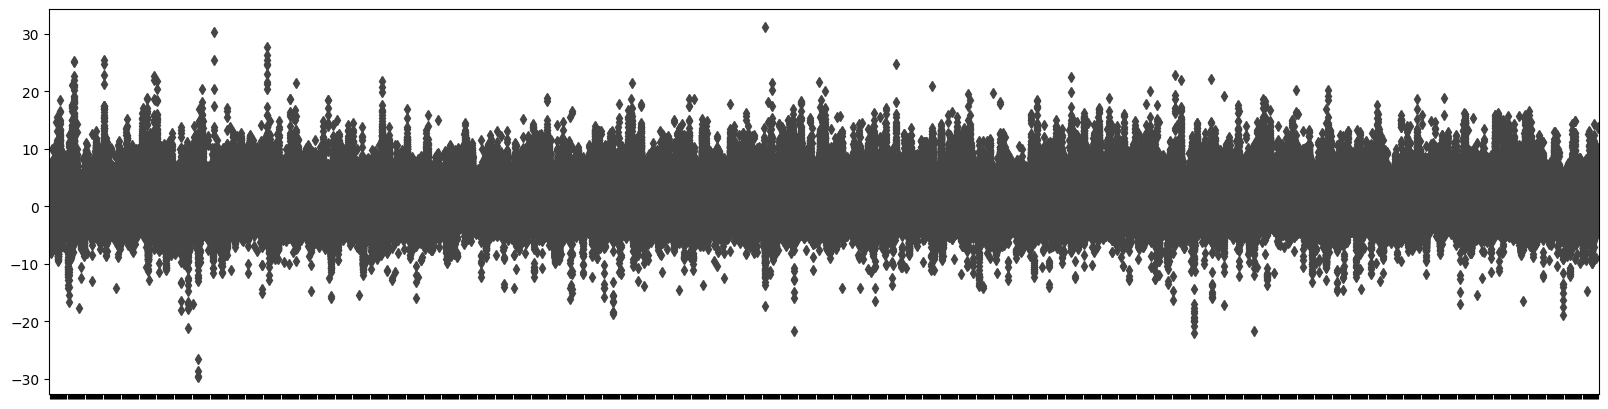

In [5]:
x = SimpleImputer(strategy="median").fit_transform(df)
x = StandardScaler().fit_transform(x)
x = pd.DataFrame(x, columns=df.columns, index=df.index)
print_boxplots(x)

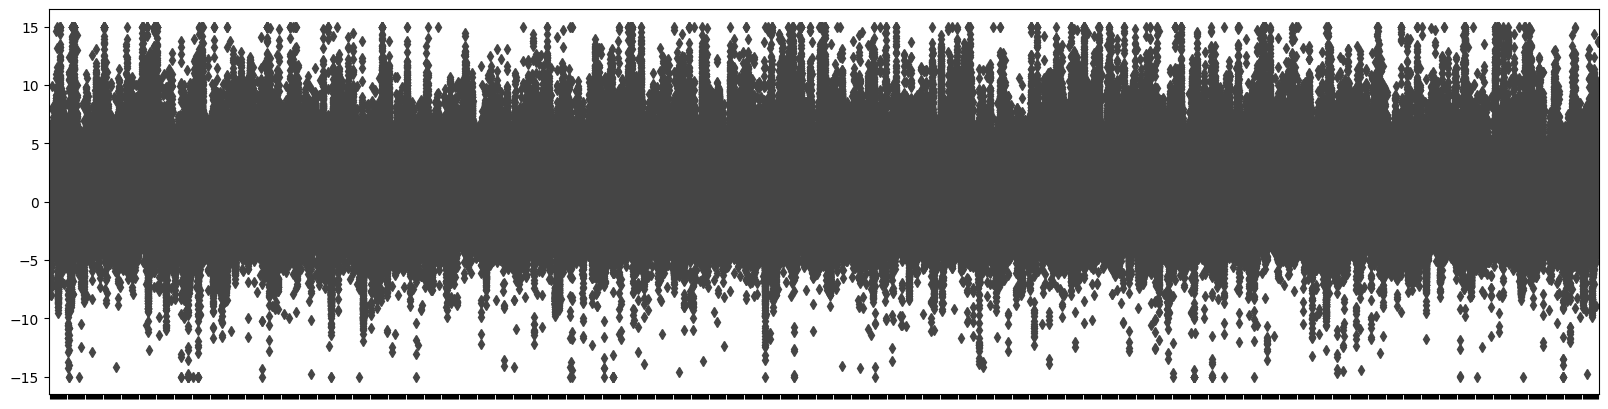

In [6]:
x.clip(lower=-15, upper=15, inplace=True)
print_boxplots(x)

In [7]:


reducer_grid_spec = {
    "umap": {
        "metric": [
            "manhattan", "euclidean",
            "cosine", "correlation",
        ],
        "n_components": [2],
        "n_neighbors": [50, 100],
    },
    "tsne": {
        "n_components": [2],
        "perplexity": [15, 30, 50],
    },
    "phate": {
        "n_components": [2],
        "knn": [10, 20, 40],
        "decay": [20, 40, 60]
    }
}

clust_grid_spec = {
    "kmeans": {
        "n_clusters": [2, 3, 4, 5],
    },
    "hdbscan": {
        "min_cluster_size": [10, 30],
    },
}


def run_case(params):
    params["reducer"] = params.pop("algorithm")
    emb = get_embedding(data=x, **params)

    results = []
    for clust_param_set in to_test_cases(clust_grid_spec):
        cluster_labels = get_cluster_labels(data=emb, **clust_param_set)
        clust_param_set["clust_alg"] = clust_param_set.pop("algorithm")

        score = score_clustering(emb, cluster_labels)
        results.append({
            **score,
            **params,
            **clust_param_set
        })
    return results


results = Parallel(n_jobs=20)(
    delayed(run_case)(params) for params in tqdm(to_test_cases(reducer_grid_spec)))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 42.02it/s]


In [8]:
score_df = pd.DataFrame.from_records(chain.from_iterable(results))
score_df = score_df.sort_values(by="silhouette", ascending=False).reset_index(drop=True)
score_df.head(20)

,silhouette,calinski_harabasz,davies_bouldin,label_counts,metric,n_components,n_neighbors,reducer,n_clusters,clust_alg,min_cluster_size,perplexity,knn,decay
0,0.744013,1855.774983,0.205374,"[83, 52621]",NaN,2,NaN,phate,NaN,hdbscan,10.0,NaN,40.0,40.0
1,0.732784,1754.799269,0.214074,"[83, 52621]",NaN,2,NaN,phate,NaN,hdbscan,10.0,NaN,40.0,60.0
2,0.658253,1587.650846,0.232756,"[93, 84, 52527]",cosine,2,50.0,umap,NaN,hdbscan,30.0,NaN,NaN,NaN
3,0.617638,1263.271829,0.260137,"[85, 91, 52528]",cosine,2,100.0,umap,NaN,hdbscan,30.0,NaN,NaN,NaN
4,0.608709,1147.746545,0.385430,"[52541, 83, 80]",NaN,2,NaN,phate,NaN,hdbscan,10.0,NaN,20.0,40.0
5,0.573356,102523.833984,0.616785,"[23446, 29258]",correlation,2,100.0,umap,2.0,kmeans,NaN,NaN,NaN,NaN
6,0.562408,96231.862738,0.635675,"[23144, 29560]",correlation,2,50.0,umap,2.0,kmeans,NaN,NaN,NaN,NaN
7,0.533610,1182.324079,0.962018,"[254, 35, 85, 44, 52286]",NaN,2,NaN,phate,NaN,hdbscan,30.0,NaN,10.0,40.0
8,0.517911,75173.226177,0.676474,"[22631, 30073]",NaN,2,NaN,phate,2.0,kmeans,NaN,NaN,40.0,20.0
9,0.507316,68464.513876,0.701633,"[31218, 21486]",NaN,2,NaN,phate,2.0,kmeans,NaN,NaN,10.0,20.0


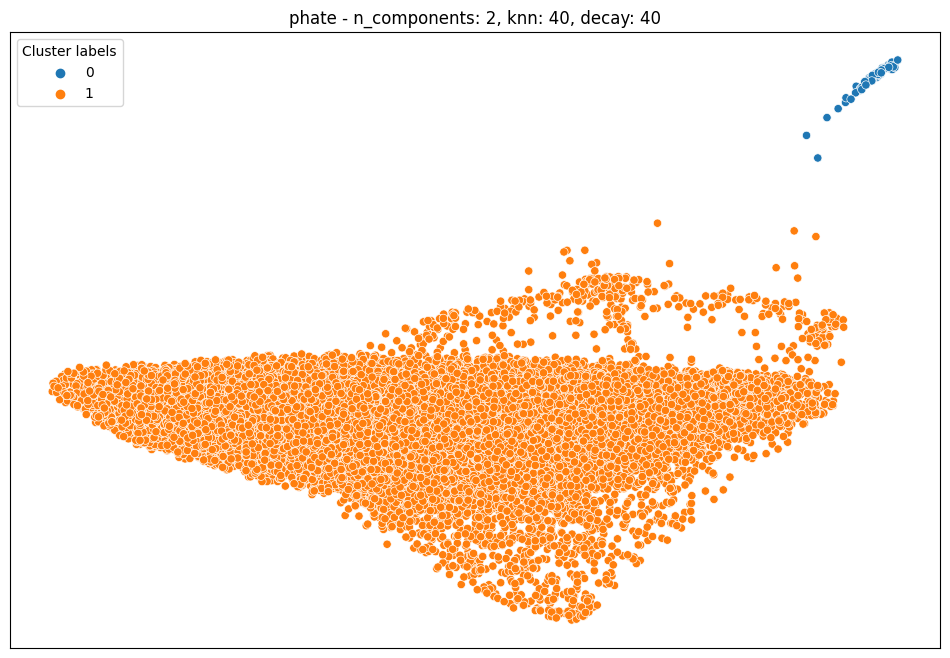

In [9]:
n = 0
params = score_df.iloc[n].to_dict()
reducer = params["reducer"]
reducer_params = {k: int(v) if isinstance(v, float) else v for k, v in params.items() if
                  k in reducer_grid_spec[reducer]}

embedding = get_embedding(data=x, reducer=reducer, **reducer_params)

clust_alg = params["clust_alg"]
clust_alg_params = {k: int(v) for k, v in params.items() if k in clust_grid_spec[clust_alg]}
cluster_labels = get_cluster_labels(embedding, algorithm=clust_alg, **clust_alg_params)
cluster_labels.name = "Cluster labels"

if params["n_components"] == 2:
    title = f"{reducer} - " + ", ".join([f"{k}: {v}" for k, v in reducer_params.items()])
    ax = plot_clustering(embedding, cluster_labels, title=title)

In [11]:
col_pvals = print_best_features(cluster_labels, df)

ValueError: `x` and `y` must be of nonzero size.

In [ ]:
visualize_clustering(embedding, df[[col for col, _ in col_pvals[:10]]].reset_index(drop=True),
                     cluster_labels)

In [ ]:
explain_clusters(cluster_labels, x=x, x_orig=df,
                 xgb_params=dict(n_estimators=2, max_depth=6),
                 max_display=15)